Detected classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25, Train Loss: 0.4595, Val Loss: 0.2332, Val Acc: 92.29%
Epoch 2/25, Train Loss: 0.2344, Val Loss: 0.2163, Val Acc: 93.02%
Epoch 3/25, Train Loss: 0.1894, Val Loss: 0.2054, Val Acc: 93.54%
Epoch 4/25, Train Loss: 0.1413, Val Loss: 0.1864, Val Acc: 94.38%
Epoch 5/25, Train Loss: 0.1287, Val Loss: 0.1823, Val Acc: 95.31%
Epoch 6/25, Train Loss: 0.1136, Val Loss: 0.1575, Val Acc: 95.10%
Epoch 7/25, Train Loss: 0.0967, Val Loss: 0.1737, Val Acc: 94.90%
Epoch 8/25, Train Loss: 0.0994, Val Loss: 0.1843, Val Acc: 94.69%
Epoch 9/25, Train Loss: 0.0965, Val Loss: 0.2200, Val Acc: 94.17%
Epoch 10/25, Train Loss: 0.0840, Val Loss: 0.1993, Val Acc: 94.69%
Epoch 11/25, Train Loss: 0.0464, Val Loss: 0.1567, Val Acc: 96.15%
Epoch 12/25, Train Loss: 0.0339, Val Loss: 0.1260, Val Acc: 95.73%
Epoch 13/25, Train Loss: 0.0227, Val Loss: 0.1313, Val Acc: 96.25%
Epoch 14/25, Train Loss: 0.0193, Val Loss: 0.1169, Val Acc: 96.56%
Epoch 15/25, Train Loss: 0.0208, Val Loss: 0.1245, Val Acc: 96.15%
Epoc

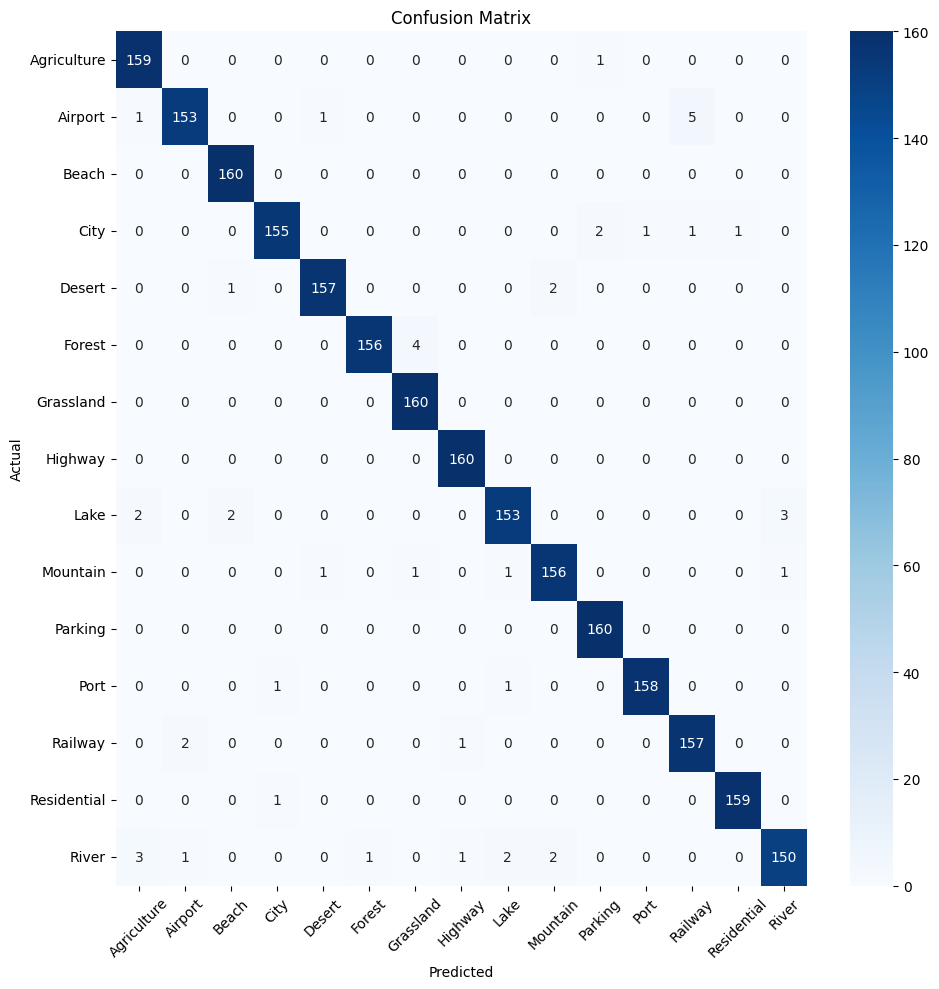

In [ ]:
import os
import zipfile
import shutil
import re
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

# Download and extract dataset
zip_dir = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
zip_file = os.path.join(zip_dir, "Aerial_Landscapes.zip")
extracted_dir = os.path.join(zip_dir, "Aerial_Landscapes")

if not os.path.exists(extracted_dir):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)

# Organize images into class folders
for file in os.listdir(extracted_dir):
    if file.endswith('.jpg'):
        match = re.match(r'([A-Za-z]+)', file)
        if match:
            class_name = match.group(1)
            class_dir = os.path.join(extracted_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            shutil.move(os.path.join(extracted_dir, file), os.path.join(class_dir, file))

# Transform with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=extracted_dir, transform=transform)
class_names = full_dataset.classes
print("Detected classes:", class_names)

# Stratified train/test split
targets = [label for _, label in full_dataset]
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(np.zeros(len(targets)), targets))
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

# Further split train into train/val
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup (ResNet-18)
model = models.resnet18(pretrained=True)

# Unfreeze layer4 and fc for fine-tuning
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 15)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=25):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation loss
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        scheduler.step()
        val_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Train and evaluate
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=25)
labels, preds = evaluate_model(model, test_loader)

# Report and confusion matrix
print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=class_names))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
